# Numerical simulation of two-photon sideband transitions between a superconducting qubit and cavity
This notebook provides methods to simulate two-photon sideband transitions in a quantum system consisting of a driven superconducting qubit coupled to a cavity.

It is structured with the following sections:
0. Import packages and modules.
1. Parameters and settings. All the required parameters and settings for the device, the system, and the experiment.
2. Calculate. Perform the time simulation.
3. Process results. Save the parameters, combine separate batches per quantity and calculate the sideband transition rate.
4. Plot results.
5. Save results. Change temporary folder to saved folder, when you are satisfied with the data.

Appendix A. Scanning. Sweep drive or probe frequency to find
- required drive frequency for sideband transitions,
- driven qubit frequency, or
- cavity frequency, when coupled to a driven qubit.

This notebook makes use of open-source packages like QuTiP, and of supplementary cQED modules built in-house. Here follows a very brief description of what these cQED modules contain:
- `calculate`: functions calculating the evolution, required drive frequency and transition rate,
- `envelopes`: functions providing time dependence of Hamiltonian terms for QuTiP's solver,
- `scan`: functions to simulate for a given driving or probe frequency, and other given parameters,
- `process`: functions processing the data, and handling batches and folders,
- `plotsettings`: plot settings that will be used for all generated plots,
- `plots`: functions to plot the obtained data from the simulation,
- `supports`: several global variables and function to reduce typing, and other functions.

While this notebook is preferably written for performing simulations, the `analyze` notebook is recommended to be used for analysis of performed simulations.

#### 0. Import packages and modules

In [1]:
# Magic commands
%matplotlib inline
%matplotlib notebook

# External packages
import os
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from qutip import *
from pylab import *
from ipywidgets import widgets
from IPython.display import display, HTML

# cQED modules
from plotsettings import *
from plots import *
from supports import *
from process import *
from calculate import *
from envelopes import *
from scan import *

home = os.getcwd() + "/"

# 1. Parameters and settings
Let's first define all the parameters for our device and experiment. Note that all frequency- and energy-related variables are in units of ns and Grad/s, and that we work with natural units of $\hbar=1$.

### Anharmonicity
When the qubit has more than two energy levels ($N_q > 2$), this notebook gives us two ways to deal with the anharmonicity between the levels. We can choose for a Duffing oscillator, where the qubit's bare, intrinsic Hamiltonian is given by

\begin{equation}
    \hat{H}_q = \omega_q' \hat{b}^\dagger \hat{b} - \frac{E_C}{12} \left( \hat{b} + \hat{b}^\dagger \right) ^4,
\end{equation}

where $\omega_q' = \sqrt{8E_J E_C}$ is the bare qubit frequency. This form is derived from the transmon regime where $E_J / E_C \gg 1$ and where the anharmonicity is only a small perturbation on the harmonic behaviour (029). We can also choose for the common Kerr approximation which removes all off-diagonal elements from the fourth-power term, corresponding to the rotating wave approximation (RWA) by removing the fast rotating terms in the interaction picture. The qubit's Hamiltonian then becomes

\begin{equation}
    \hat{H}_q = \omega_q \hat{b}^\dagger \hat{b} - \frac{E_C}{2} \hat{b}^\dagger \hat{b}^\dagger \hat{b} \hat{b},
\end{equation}

where $\omega_q = \omega_q' - E_C$. The first option can be chosen by setting the boolean variable `anh_appr` to `False`, the second by setting it to `True`.

Note that in the case that $N_q = 2$ (TLS), the anharmonicity term does nothing to the behaviour of the system and can be safely kept in the Hamiltonian.

### Driving sideband transitions
<table width="400">
    <tr>
        <td>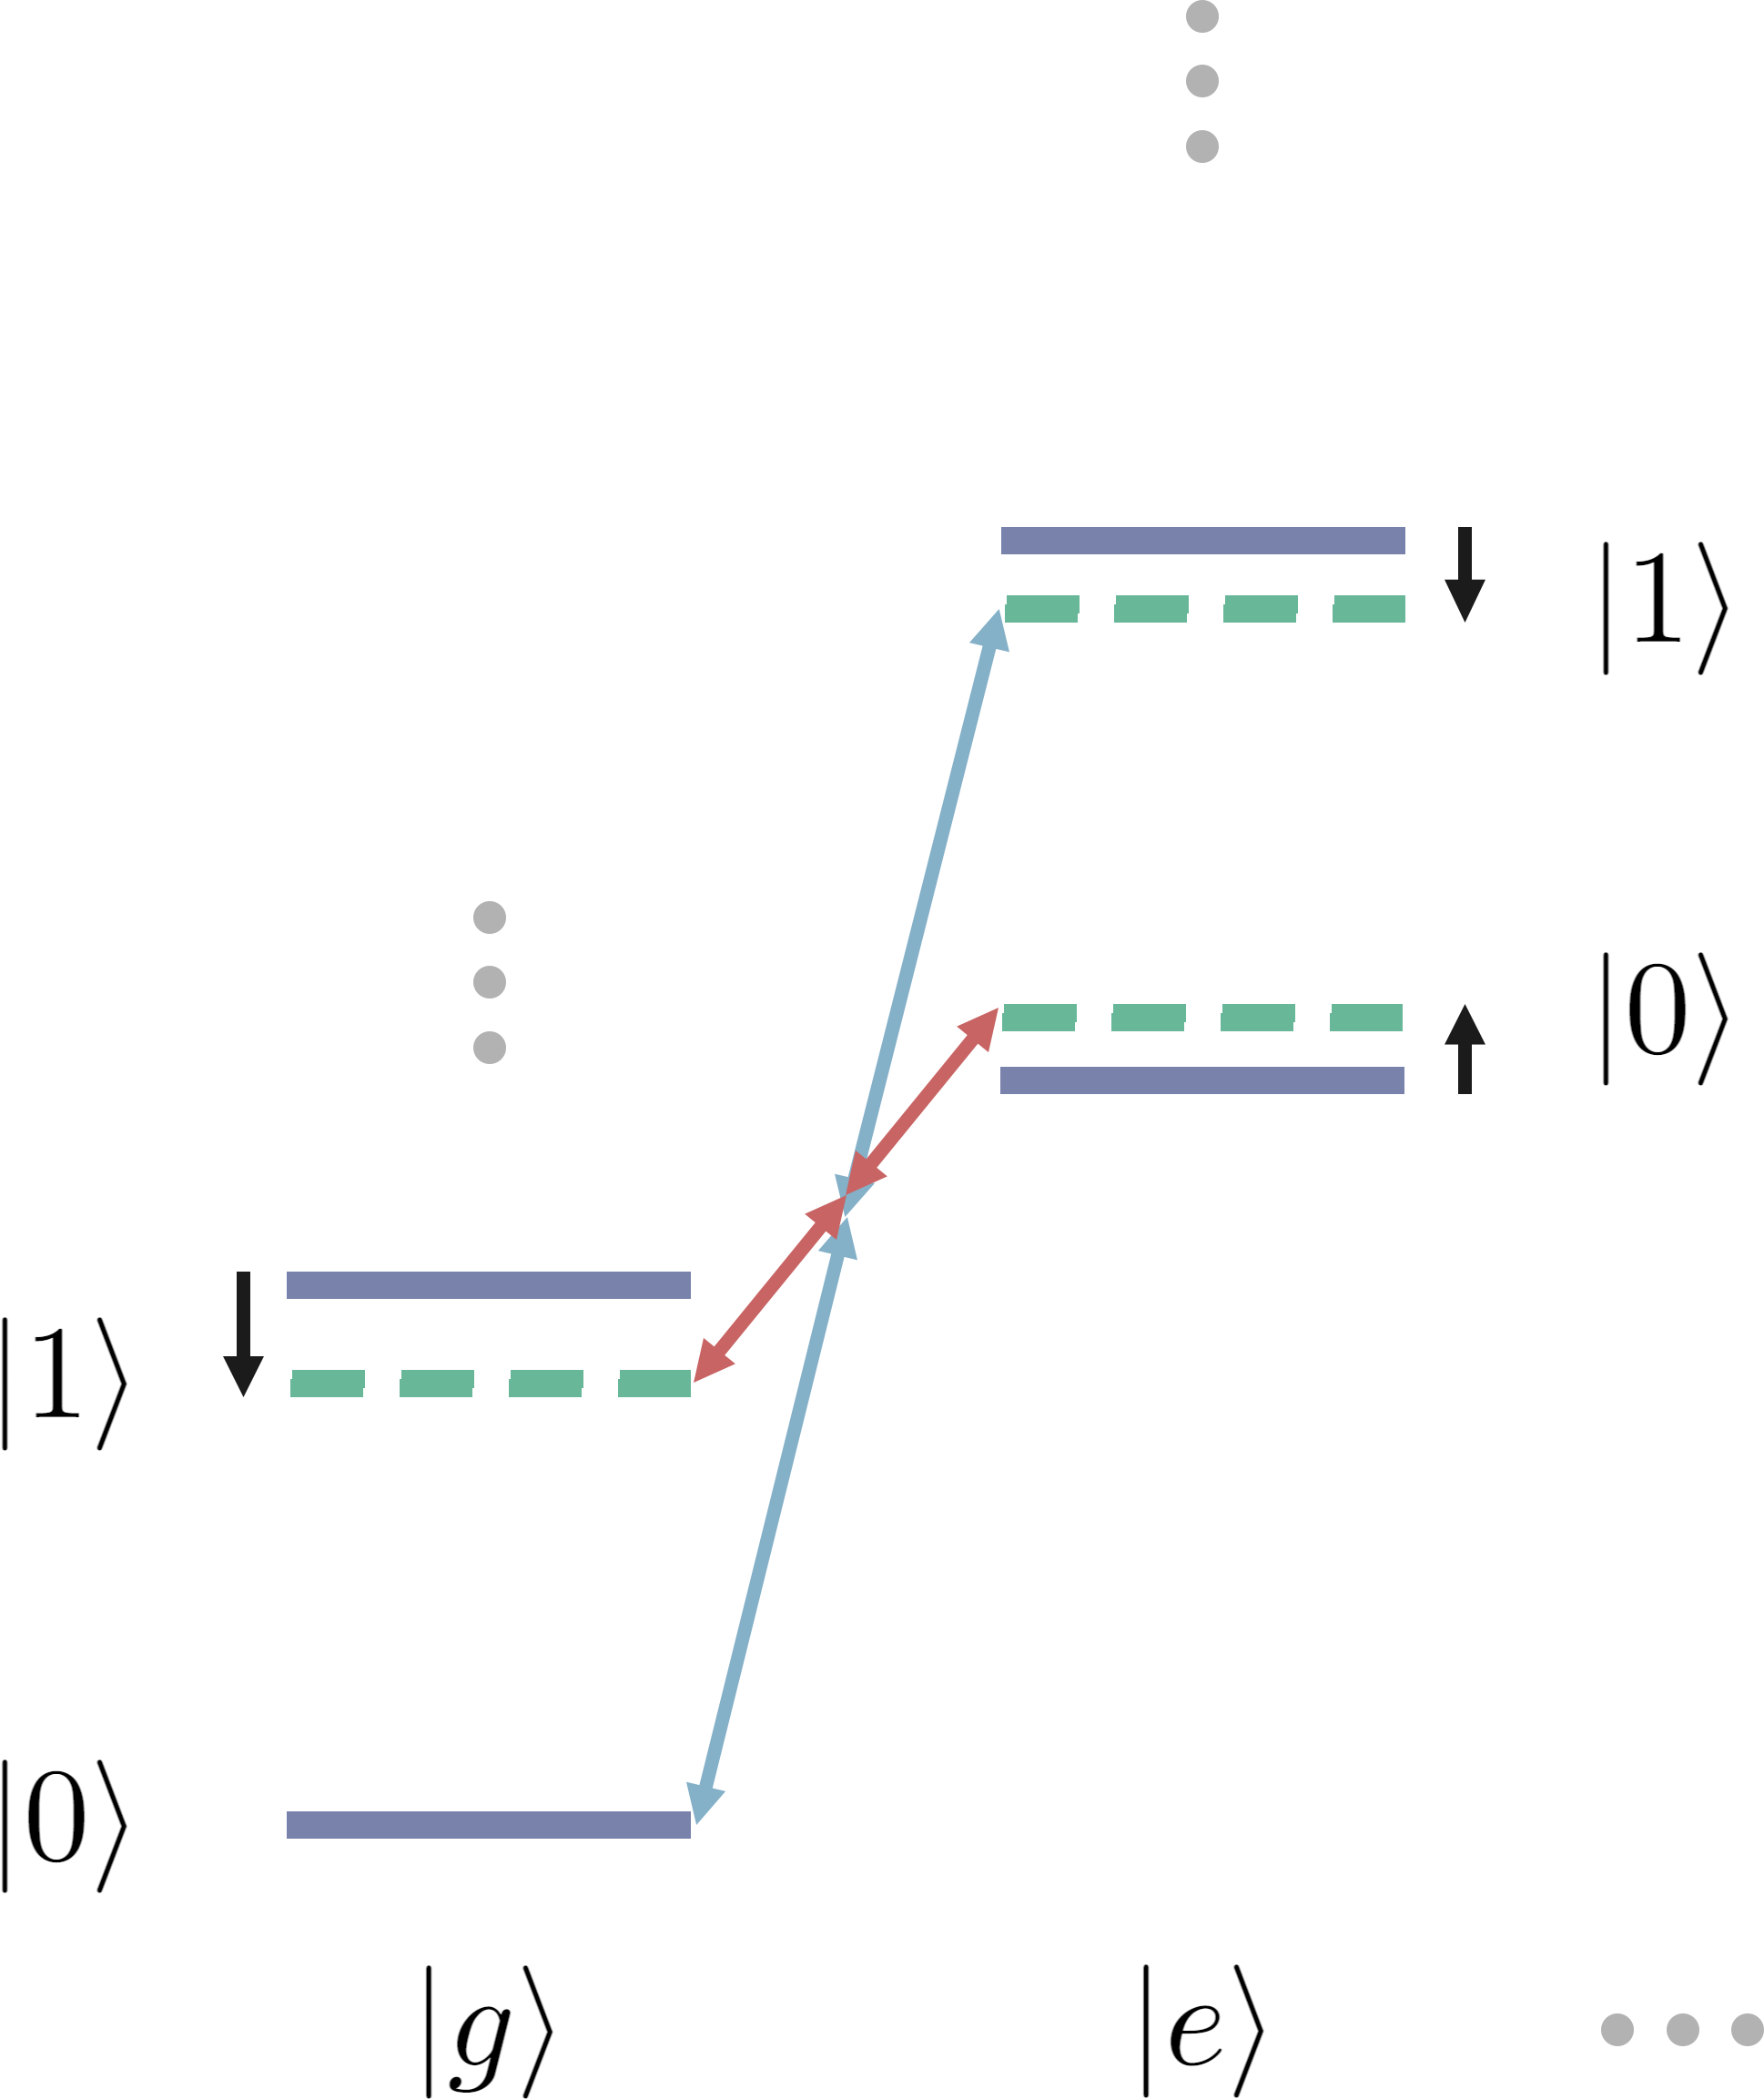</td>
        <td>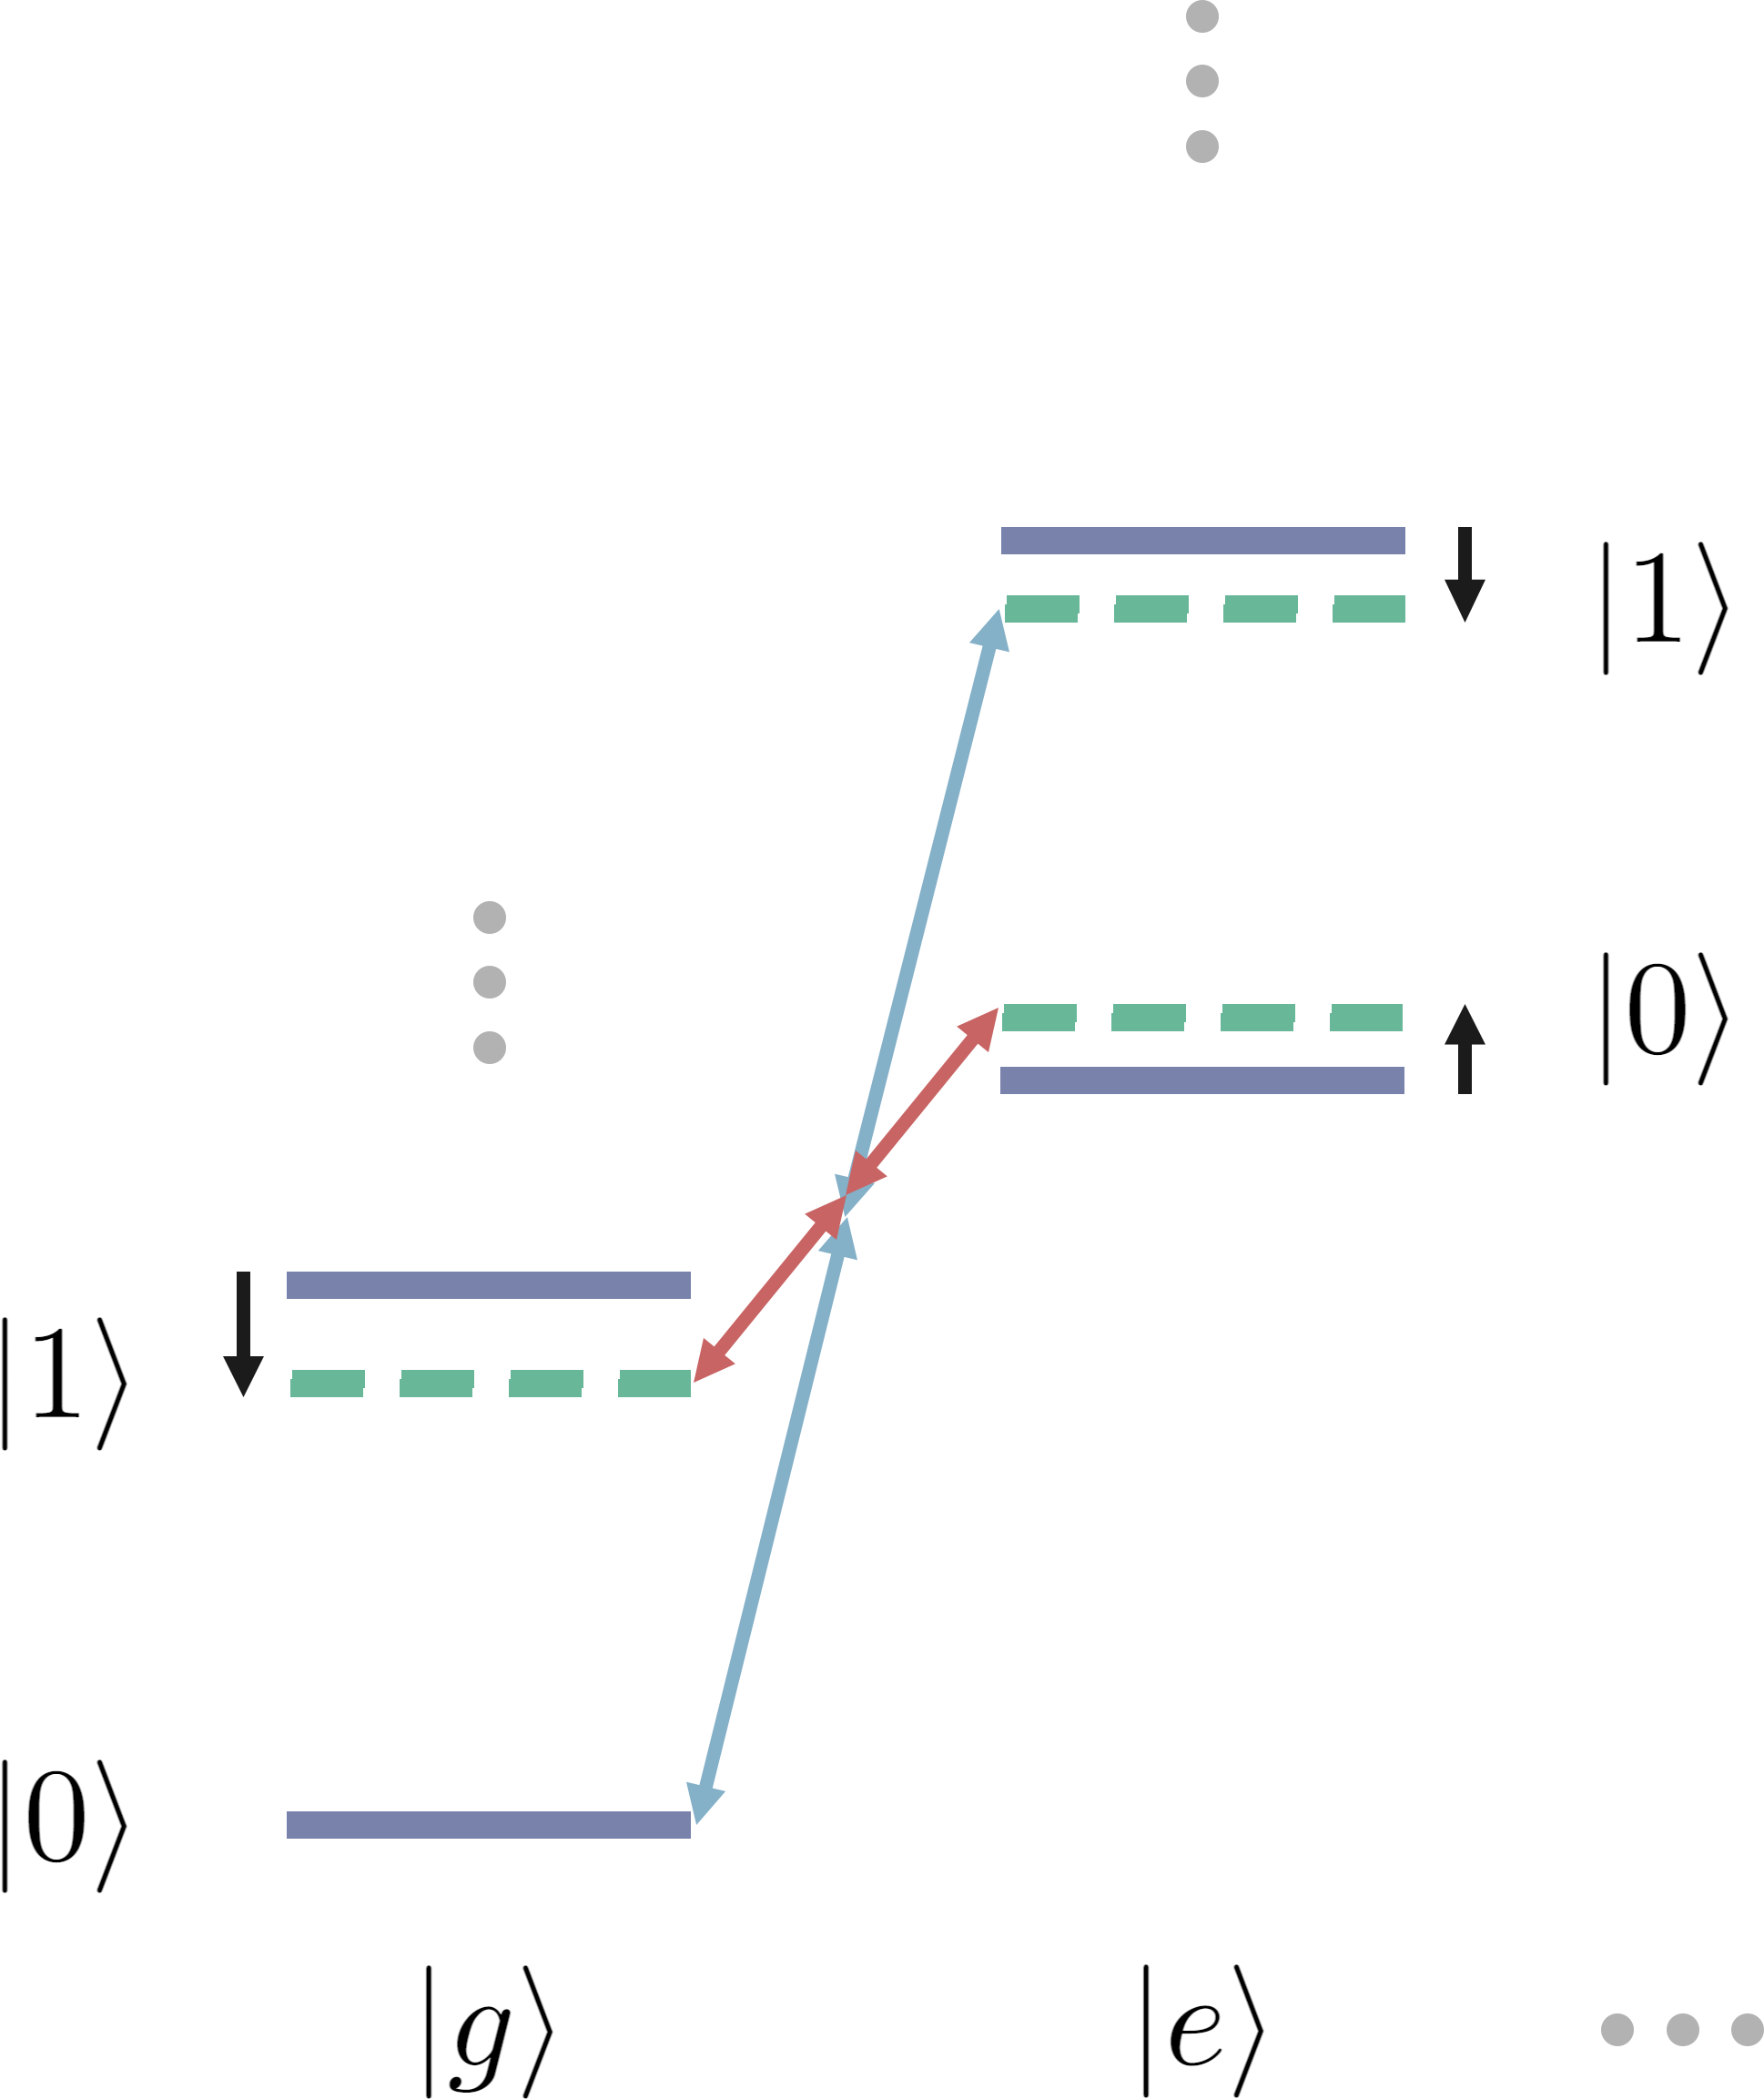</td>
    </tr>
</table>

The type of sideband transition is set by the variable `sb` and is either `'red'` ($\left|e0\right>$-$\left|g1\right>$) or `'blue'` ($\left|e1\right>$-$\left|g0\right>$). This notebook allows the drive to be either monochromatic ($N_t = 1$) or bichromatic ($N_t = 2$), but the transitions always include two photons. That is because single-photon (first-order) transitios are prohibited for a transmon and for a TLS at the sweet spot.

In the case of bichromatic driving, the two photons involved in a transition are of different frequencies. The cavity-friendly tone is detuned by an amount `dw` from the bare cavity frequency, which should have a value small enough to keep the transition rate sufficiently high, but large enough so that there is no independent emission or absorption by the cavity. The qubit-friendly drive tone is then the one that induces either the red or blue sideband transitions.

### Time cycle
These parameters determine the length of the simulation in time and at an what time the drive and coupling are turned on and of.

### Rise and fall of drive and coupling
Because the system is by default initiated in an eigenstate of the uncoupled system, it is convenient to initiate the system uncoupled and smoothly increase the coupling and driving strength. This is to reduce oscillatory quantum behaviour of a system that is not in one of its eigenstates. This rise and fall is done by the boolean variable `gauss`. It lets the coupling and driving strength rise and fall according to a Gaussian shape. The duration of the rise and fall, and the number of standard deviations within one rise or fall are set by `tg` and `Q`, respectively.

### Convergent method
As long as the qubit and cavity are coupled and driven, they will show oscillatory exchange of energy. These oscillations in energy, however, are not what we would measure in reality. What we would measure though, after many runs, is the population of the qubit and cavity after they have been uncoupled and the driving has stopped. When gradually decreasing the coupling and driving strength, the oscillations converge to the value we would measure at $t_3$. The convergent method generates the points over time to which the oscillations converge. This method is switched on by setting the `convergent` variable to `True`.

In [60]:
# Device 
Nq = 10         # number of levels in qubit
Nc = 10         # number of levels in resonator 1
wq = 6.8126 *2*pi  # g-e qubit transition frequency
wc = 4.0831 *2*pi  # bare resonator frequency
Ec = 0.1374 *2*pi  # anharmonicity (charging energy)
g  = 0.1290 *2*pi  # coupling between qubit and resonator
kq = 0.0 *2*pi  # qubit linewidth
kc = 0.0 *2*pi  # cavity linewidth

# Anharmonicity approximation
anh_appr = False  # remove off-diagonal elements from H_anh?
anh_power = 4

# Sideband transitions
sb = 'red'  # type of sideband transitions
Nt = 1      # number of drive tones

# Single-tone
eps = 0.4 *2 *2*pi  # pump drive amplitude
wd  = 1.36753 *2*pi  # monochromatic drive frequency

# Double-tone
epsfac = 1.5                     # factor with which to scale the drive tone amplitudes
epsq   = epsfac * 0.025 *2 *2*pi  # amplitude of qubit-friendly drive tone
epsc   = epsfac * 0.317 *2 *2*pi  # amplitude of cavity-friendly drive tone
dw     = 0.5 *2*pi               # detuning of wdc from wc
wdq    = 4.4468 *2*pi            # frequency of qubit-friendly drive tone
wdc    = wc - dw                 # frequency of cavity-friendly drive tone

# Time cycle
t0 = 0         # start of simulation
t1 = t0 + 0    # start of drive and coupling
t2 = t1 + 20020  # end of drive of drive and coupling
t3 = t2 + 0    # end of simulation

# Gaussian rise and fall
tg = 10         # length of gaussian rise and fall
gauss = True    # whether or not to rise and fall with gaussian
smooth = False  # whether to start gaussian at 0 or with small jump
Q = 3           # number of std's in gaussian rise and fall

# Convergent method
convergent = True  # use convergent method

# Integration
method = 'bdf'  # mesolve's integration method, either 'bdf' or 'adams'

## Autofill
Above are the parameters that most frequently need to be set and changed. The three cells below contain
- parameters that are usually kept unchanged,
- lines that take already defined parameters and create new variables or objects based on those parameters.

### Total Hamiltonian
Because of the periodic drive and the rise and fall of the coupling, the total Hamiltonian is time-dependent. It is given by

\begin{align}
    \hat{H} & = \hat{H}_q + \hat{H}_c + \hat{H}_g (t) + \hat{H}_d (t)\\
            & = \hat{H}_q + \omega_c \hat{a}^\dagger \hat{a} + g(t) (\hat{b} + \hat{b}^\dagger) (\hat{a} + \hat{a}^\dagger)
            + \epsilon_d(t) \cos (\omega_d t) (\hat{b} + \hat{b}^\dagger)
\end{align}

where $\hat{H}_q$ is given by the choice of anharmonocity above. In the case of bichromatic driving, $\hat{H}_d$ is given by

\begin{equation}
    \hat{H}_d = \epsilon_{dq}(t) \cos (\omega_{dq} t) (\hat{b} + \hat{b}^\dagger) + \epsilon_{dc}(t) \cos (\omega_{dc} t) (\hat{b} + \hat{b}^\dagger),
\end{equation}

where the subscript $dq$ represents the qubit-friendly drive tone, and $dc$ the cavity-friendly drive tone. The time dependence is passed on to the solver by functions defined in the `envelopes` module. `H_args` is a dictionary containing variables required for proper handling of the time dependence of $\hat{H}$.

In [61]:
b, a, nq, nc = ops(Nq, Nc)  # Operators
Ej = (wq + Ec)**2 / (8*Ec)  # Josephson energy

# Individual Hamiltonian terms
if anh_appr or Nq == 2:
    Hi = wq*nq + wc*nc - Ec/2*b.dag()*b.dag()*b*b  # devices intrinsic
else:
    Hi = (wq+Ec)*nq + wc*nc - Ec/12*(b + b.dag())**4
    if anh_power == 6:
        Hi += np.sqrt(2)/360*Ec*np.sqrt(Ec/Ej)*(b + b.dag())**6
Hc = g*(a + a.dag())*(b + b.dag())  # coupling
if Nt == 1:
    Hdp = eps/2*b
    Hdm = eps/2*b.dag()

# Combine terms to complete Hamiltonian and include time dependence
if Nt == 1:
    H = [Hi, [Hc, drive_nonosc], [Hdm, drive_no_CR_p], [Hdp, drive_no_CR_m]]

# Store time dependence arguments for solver
if Nt == 1:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q'  : Q, 'gauss' : gauss,
              'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'wd' : wd}
elif Nt == 2:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q'  : Q, 'gauss' : gauss,
              'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'wdq' : wdq, 'wdc' : wdc}

### Estimate for the required drive frequency
Based on analytical formulae and diagonalization of the time-independent Hamiltonian

\begin{align}
    \hat{H} & = \hat{H}_q + \hat{H}_c + \hat{H}_g\\
            & = \hat{H}_q + \omega_c \hat{a}^\dagger \hat{a} + g (\hat{b} + \hat{b}^\dagger) (\hat{a} + \hat{a}^\dagger),
\end{align}

the shift of the energy levels can de estimated, and with that the required driving frequency. This estimate is calculated by `drivefreq` from the `calculate` module and is printed below.

In [62]:
# Estimate the required drive frequency
_ = drivefreq(Nq, wq, wc, Hi+Hc, sb, Nt, eps=eps, epsq=epsq, epsc=epsc, dw=dw, Ec=Ec,
              resolution=0.001*2*pi, verbose=True, method='SBS', anharm='lin')

Estimated drive frequency wd = 1.3667 GHz


### Initial state
We initialize the system in an eigenstate of the uncoupled system, that is in a Fock state of the qubit and of the cavity. The initial state depends on the type of sideband transition. In the red case, the transitions are between $\left|e0\right>$ and $\left|g1\right>$, so either the qubit should be initialized excited and the cavity in its ground state or the other way around. The blue sideband transitions are between the $\left|e1\right>$ and $\left|g0\right>$ states. In this case, it is most convenient to initiate the system in its ground state $\left|g0\right>$.

### Time steps and batches
We can choose the number of equidistant points `Np` in time for which the solver stores the output. In between these points, QuTiP's `Options` class provides the choice of the maximum number of points that can be used for integration. Large `Np` will provide detailed plots of the evolution but will, needlessly to say, consume more memory.

Since it is convenient to save the entire evolution for later use, the states $\psi(t)$ of the system are kept. But these objects will quickly consume large amounts of RAM. So the evolution is automatically divided into batches. The system's evolution within one batch (corresponding to a specific period of time) is saved to a `pickle` file in the '/temp/' folder and deleted from RAM. Later on, the expectation values through the entire evolutions are retrieved from these files again.

There will probably be an optimum value for the number of points per batch that minimizes the computation time of writing data to files and keeping many variables in the RAM, but I have never calculated what this ratio would be. 10 ns per batch, with time steps of 10 ps seems to work well.

The convergent method has its own line for the number of data points. This is because this method is much more computationally intensive, since the evolution during the fall of the drive and coupling must be calculated again for each new data point. So make sure that, for reasonable computation times, you do not choose `Np` too large.

In [63]:
# Set the initial state based on the type of sideband transition
if sb == 'red':
    psi0 = tensor(basis(Nq, 1), basis(Nc, 0))  # Red: qubit excited, cavity in ground state
elif sb == 'blue':
    psi0 = tensor(basis(Nq, 0), basis(Nc, 0))  # Blue: both qubit and cavity in ground state

# Set the expectation and collapse operators for the solver
e_ops = [nq, nc]  # expectation operators
c_ops = []        # collapse operators

# Set the options for the Lindblad ME solver
options = Options()
options.store_states=True
if method == 'bdf':
    options.method = 'bdf'
    options.rtol = 1e-10
    options.atol = 1e-10
else:  # adams
    options.nsteps = 1000
    options.rtol = 1e-10
    options.atol = 1e-10
    options.max_step = 0

# Set the time steps for which to store the output of the solver
if not convergent:
    Np = 10 *int(t3)  # number of equidistant data points in time
    print("timestep =", 1e3*np.round(t3/Np, 5), "ps")
elif convergent:
    Np = 0.005 *int(t3-2*tg)    # number of equidistant data points in time
    print("timestep =", 1e3*np.round((t3-2*tg)/Np, 5), "ps")
Np_per_batch = Np/int(np.round(t3/10))  # number of time points per batch

timestep = 200000.0 ps


# 2. Calculate
Now we have set all the parameters to numerically calculate the system's evolution over time! This is done by the `calculate` function of the `calculate` module. It saves the evolution for each batch and returns the name of the folder with all the data. This folder name can be used as a reference for the simulation, but also the ID it is given, which is a date and time stamp to second precision.

Important note: all folders within the '/temp/' folder are removed when running the `calcuate` function and its `parallel` argument is set to `False`.

In [64]:
progfolder = calculate(H, psi0, e_ops, c_ops, H_args, options, Nc, Np, Np_per_batch, home,
                       parallel=False, verbose=True, refinement=1000, method='me')

Progress: |██████████████████████████████████████████████████| 100.0%
Evolution completed in 91 min


# 3. Process results
Now that the calculations are finished we have to process the data and take care of the results.

### Save parameters
First, we are going to save all the parameters to a file (.txt and .pkl), for easy documentation and readout.

In [65]:
# Save the parameters that are used
if Nt == 1:
    saveparams(Nq, Nc, Nt, wq, 0, wc, Ec, g, sb, t0, t1, t2, t3, tg, anh_appr, gauss, smooth, Q, convergent,
               Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'], eps=eps, wd=wd)
elif Nt == 2:
    saveparams(Nq, Nc, Nt, wq, 0, wc, Ec, g, sb, t0, t1, t2, t3, tg, anh_appr, gauss, smooth,
               Q, convergent, Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'],
               epsq=epsq, epsc=epsc, wdq=wdq, wdc=wdc, dw=dw)

### Load parameters
Then we load all parameters from the `pickle` file into RAM. It may seem odd and unnecessary to this, since they are all defined above. The reason is that the next cell provides the functionality to load from any data folder available, and that specific simulation may have other settings. `srcfolder` should be the path that leads to this folder.
I advise, though, to make use of the `analyze` notebook for analysis of previously performed simulations.

In [66]:
# Load parameters
srcfolder = progfolder  # path to the folder to get the data from

start_comb = datetime.now()
new_folder_name = copy(srcfolder)
ID = getID(srcfolder)  # unique simulation ID

# Get the parameters that are used
Nq, Nc, Nt, wq, _, wc, Ec, g, sb, t0, t1, t2, t3, tg, anh_appr, gauss, smooth, Q, convergent, Np, H, psi0, e_ops, options, eps, wd, epsq, epsc, dw, wdq, wdc = getparams(srcfolder)
if Nt == 1:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q' : Q,
              'gauss' : gauss, 'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'wd' : wd}
elif Nt == 2:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q' : Q, 'gauss' : gauss,
              'smooth' : smooth,  'convergent' : convergent, 'Nt' : Nt, 'wdq' : wdq, 'wdc' : wdc}

### Extract calculated quantities
At this point, all calculated quantities such as expectation values and occupation probabilities are still divided over multiple batches, but we want these quantities as individual objects for easy handling. Therefore we extract these quantities from the individual batches and save them to dedicated `pickle` files and load them into RAM. `quants` determines for which quantities this is done.
Note that loading all the quantum states with the argument `states` will probably consume all your memory and crash the system.

In [67]:
# Combine all batches per quantity
quants = ['times', 'expect', 'e0', 'g1', 'e1', 'g0', 'coupling']  # quantities to extract from data folder

combine_batches(srcfolder, quants=quants, return_data=False)
print("Batches combined    in {} s".format((datetime.now() - start_comb).total_seconds()))

times, states, expect, e0, g1, e1, g0, coupling = load_data(quants, srcfolder)  # load to RAM

Batches combined    in 3.584006 s


### Calculate sideband transition rate
With the obtained data we can measure the sideband transition rate $\Omega_{sb}$ by looking at the extrema of the combined prbabilities:
- $P({\left|e0\right>}) - P({\left|g1\right>})$ for the red sideband transitions, and
- $P({\left|e1\right>}) - P({\left|g0\right>})$ for the blue sideband transitions.

But due to the driving, there will be micromotion present in the signal, resulting in many extrema. This micromotion should be filtered out first before determining the transition rate. This is done by the `remove_micromotion` function from the `calculate` module, which accepts 3 choices of method:
- `'savgol'`: Savitsky-Golay filter,
- `'bisect'`: data point in the middle of the bisectional line connecting two neighbouring extrema,
- `'lowpass'`: low-pass filter.

The transition rate is subsequently calculated by `sideband_freq`. If the systen has not undergone one full oscillation, a warning is raised and the transition rate will be set to zero.
Note that the rise and fall influence the local evolution. Therefore extrema that fall within the rise and fall are not included in determining the transition rate.

In [68]:
# Determine the sideband transition rate
smoothen_method = 'savgol'  # method to remove micromotion, either 'savgol', 'bisect', or 'lowpass'

if not convergent:
    if 'e0' in quants:
        e0_macro, e0_macro_times = remove_micromotion(e0, times, method=smoothen_method)
    if 'g0' in quants:
        g0_macro, g0_macro_times = remove_micromotion(g0, times, method=smoothen_method)
    if 'e1' in quants:
        e1_macro, e1_macro_times = remove_micromotion(e1, times, method=smoothen_method)
    if 'g1' in quants:
        g1_macro, g1_macro_times = remove_micromotion(g1, times, method=smoothen_method)
    if ('e1' in quants and 'g0' in quants):
        e1g0_macro, e1g0_macro_times = remove_micromotion(e1-g0, times, method=smoothen_method)
    if ('e0' in quants and 'g1' in quants):
        e0g1_macro, e0g1_macro_times = remove_micromotion(e0-g1, times, method=smoothen_method)

    if sb == 'red':
        wsb = sideband_freq(e0g1_macro, e0g1_macro_times)
    elif sb == 'blue':
        wsb = sideband_freq(e1g0_macro, e1g0_macro_times)

elif convergent:
    if sb == 'red':
        wsb = sideband_freq(e0-g1, times)
    elif sb == 'blue':
        wsb = sideband_freq(e1-g0, times)

print("sideband transition freq   wsb = {} GHz".format(wsb/2/pi))
if wsb > 0:
    print("sideband transition period Tsb = {} ns".format(2*pi/wsb))

sideband transition freq   wsb = 8.684210526315788e-05 GHz
sideband transition period Tsb = 11515.151515151518 ns


# 4. Plot evolution
All these calculations and simulations are very nice of course, but let's now see what actually happens. We will plot the evolution in two different ways here:
- the expectation values of both the qubit and the cavity,
- the combined probability $P({\left|e0\right>}) - P({\left|g1\right>})$ in the case of red sideband transitions and $P({\left|e1\right>}) - P({\left|g0\right>})$ in the case of blue.

<IPython.core.display.Javascript object>


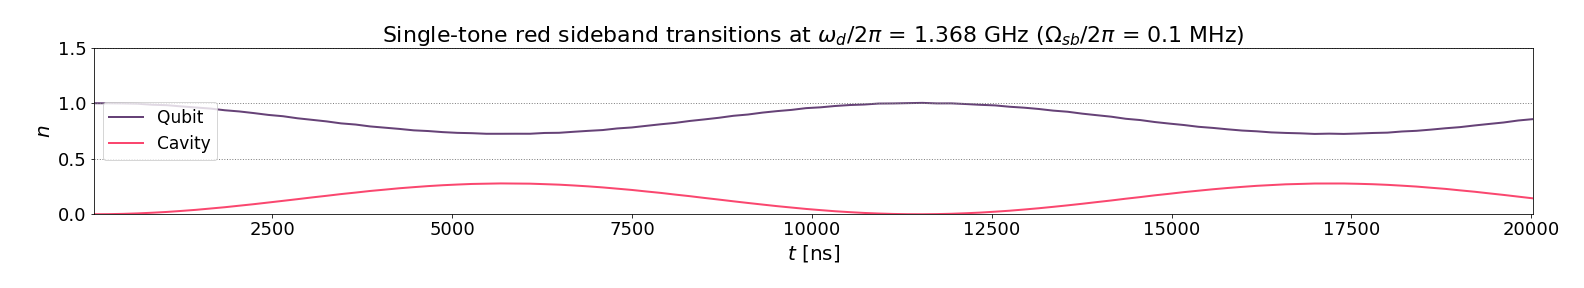

In [69]:
# Plot expectation values
xlim = None       # range of horizontal axis
ylim = None       # range of vertical axis
figsize = [22,4]  # figure size

if sb == 'red':
    if Nt == 1:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, eps=eps, wd=wd)
    elif Nt == 2:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, epsq=epsq, epsc=epsc)
elif sb == 'blue':
    if Nt == 1:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, eps=eps, wd=wd)
    elif Nt == 2:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, epsq=epsq, epsc=epsc)

<IPython.core.display.Javascript object>


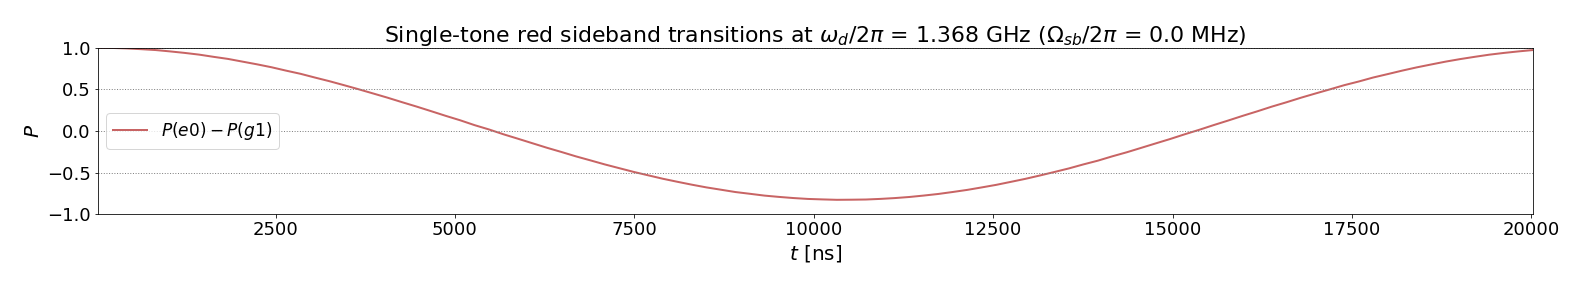

In [11]:
# Plot combined probabilities
xlim = None       # range of horizontal axis
ylim = None       # range of vertical axis
figsize = [22,4]  # figure size

if sb == 'red':
    if Nt == 1:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e0=e0, g1=g1, wd=wd, wsb=wsb, eps=eps)
    elif Nt == 2:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e0=e0, g1=g1, wsb=wsb, epsq=epsq, epsc=epsc)
elif sb == 'blue':
    if Nt == 1:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e1=e1, g0=g0, wd=wd, wsb=wsb, eps=eps)
    elif Nt == 2:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e1=e1, g0=g0, wsb=wsb, epsq=epsq, epsc=epsc)

# 5. Save data and plots
If we are satisfied with the simulation and we want to save it for later, click the button below which sais "Save data". This saves all the information, including the entire evolution, quantity files and the two above figures, to a new folder in the '/data/' folder, and removes the old temporary folder. The new folder's name contains the simulation ID and some basis parameter values. Furthermore, the sideband transition rate is added to the "parameter.txt" file.

In [13]:
# Save all data and plots with a single click on the button!
data_saved = False
data_button = widgets.Button(description='Save data')
data_out = widgets.Output()
def data_clicked(b):
    data_button.description = 'Data saved!'
    with data_out:
        global srcfolder
        
        parfile = open(srcfolder + "/parameters.txt", "a+")
        parfile.write("sideband transition frequency   wsb    : {} = {} GHz\n".format(wsb, wsb/2/pi))
        parfile.write("sideband transition coupling    gsb    : {} = {} GHz".format(wsb/2, wsb/2/2/pi))
        parfile.close()
                
        if Nt == 1:
            new_folder_name = "/home/jovyan/jupyterhub-shared/Wouter/simulation_data/data_{}_{}_Nq{}_Nt{}_Omega{}_wd{}_wq{}_wc{}_wsb{}".format(
                              ID, sb, Nq, Nt, round(eps/2/pi, 2), round(wd/2/pi, 3), round(wq/2/pi, 2),
                              round(wc/2/pi, 2), round(wsb/2/pi, 4))
            figqc.savefig(srcfolder + "/" + "figqc_{}.png".format(ID, bbox_inches='tight'))
            fig.savefig(srcfolder + "/" + "fig_{}.png".format(ID, bbox_inches='tight'))
        elif Nt == 2:
            new_folder_name = "/home/jovyan/jupyterhub-shared/Wouter/simulation_data/data_{}_{}_Nq{}_Nt{}_Omega_q{}_wdq{}_Omega_c{}_wdc{}_wq{}_wc{}_wsb{}".format(
                              ID, sb, Nq, Nt, round(epsq/2/pi, 2), round(wdq/2/pi, 3), round(epsc/2/pi, 2),
                              round(wdc/2/pi, 3), round(wq/2/pi, 2),
                              round(wc/2/pi, 2), round(wsb/2/pi, 4))
            figqc.savefig(srcfolder + "/" + "figqc_{}.png".format(ID, bbox_inches='tight'))
            fig.savefig(srcfolder + "/" + "fig_{}.png".format(ID, bbox_inches='tight'))
        shutil.move(srcfolder, new_folder_name)
        print("Folder renamed to", new_folder_name)
        srcfolder = copy(new_folder_name)
data_button.on_click(data_clicked)
widgets.VBox([data_button, data_out])

# A. Scanning

## I. Sideband transitions
For all the above, the frequency has to be given. But in order to find the correct driving frequency $\omega_d$ that induces sideband transitions we could like to sweep the driving frequency around the estimated required frequency. For every $\omega_d$ a simulation is performed with the parameters set in section 1. Parameters. The frequency range is given by `wds`. To speed up the calculation time, simulations can be run in parallel. `Npool` is the number of parallel simulations, which is of course limited by the number of available cores.

The function `sbsample` outputs two plots for every simulation with a print of the corresponding driving frequency, global maximum value of the combined probability and the global minimum. Note that before beginning the calculations, all existing folders and figures in the '/temp/' folder are deleted.

In [46]:
wds = np.linspace(1.36755*2*pi, 1.3676*2*pi, 6)  # (qubit-friendly) drive frequency range to scan
Npool = 6 # number of parallel simulations

for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all existing progfiles
for figure in glob(home + "temp/fig*"):
    os.remove(figure)  # delete all existing figures
wds = zip(range(len(wds)), wds)
pool = mp.Pool(Npool)
if Nt == 1:
    pool.starmap(sbsample, [(Nq, wq, wc, Ec, g, Wd, sb, Nt, H, H_args, psi0, c_ops, Np_per_batch, options, home, True,
                             eps) for Wd in wds])
elif Nt == 2:
    pool.starmap(sbsample, [(Nq, wq, wc, Ec, g, Wd, sb, Nt, H, H_args, psi0, c_ops, Np_per_batch, options, home, True,
                             epsq, epsc, dw) for Wd in wds])
pool.close()
for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all progfiles
print("Done.")

## II. Qubit frequency
The cell below considers only the qubit with the drive, without the cavity. An additional probe tone scans for resonance with the qubit frequency shifted by the drive. `wps` is the probe frequency range.

In [92]:
wps = np.linspace(wq+0.009*2*pi, wq+0.014*2*pi, 6)  # probe frequency range to scan1
Npool = 6                                       # number of parallel simulations
drive_on = True

for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all existing progfiles
for figure in glob(home + "temp/fig*"):
    os.remove(figure)  # delete all existing figures
wps = zip(range(len(wps)), wps)
pool = mp.Pool(Npool)
b, nq = ops(Nq)
Hq = wq*nq - Ec/2*b.dag()*b.dag()*b*b  # qubit intrinsic
Omegap = 0.005  # amplitude of probe tone
Hp = epsp*(b + b.dag())
if Nt == 1:
    Hd = eps*(b + b.dag())  # single-tone drive
    H = [Hq, [Hd, drive], [Hp, probe]]  # complete Hamiltonian
elif Nt == 2:
    Hdq = epsq*(b + b.dag())  # double-tone qubit-friendly drive
    Hdc = epsc*(b + b.dag())  # double-tone cavity-friendly drive
    H = [Hq, [Hdq, driveq], [Hdc, drivec], [Hp, probe]]  # complete Hamiltonian
if not drive_on:
    H = [Hq, [Hp, probe]]  # complete Hamiltonian
psi0 = basis(Nq, 0)
pool.starmap(qfs, [(Nq, wq, Ec, wp, H, H_args, psi0, Nc, Np, Np_per_batch, options, home, True)
                   for wp in wps])
pool.close()
for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all progfiles
print("Done.")

Done.


## III. Cavity frequency shift
The cell below considers a driven qubit, coupled to the cavity. An additional probe tone to the cavity scans for resonance with the cavity frequency, which is shifted by coupling to the driven qubit. `wps` is the probe frequency range.

In [6]:
wps = np.linspace(wc-0.017*2*pi, wc-0.022*2*pi, 6)  # probe frequency range to scan
Npool = 6                                       # number of parallel simulations
drive_on = True

for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all existing progfiles
for figure in glob(home + "temp/fig*"):
    os.remove(figure)  # delete all existing figures
wps = zip(range(len(wps)), wps)
pool = mp.Pool(Npool)
epsp = 0.005  # amplitude of probe tone
Hp = epsp*(a + a.dag())
if Nt == 1:
    H = [Hjc, [Hc, drive_nonosc], [Hd, drive], [Hp, probe]]  # complete Hamiltonian
elif Nt == 2:
    H = [Hjc, [Hc, drive_nonosc], [Hdq, driveq], [Hdc, drivec], [Hp, probe]]  # complete Hamiltonian
if not drive_on:
    H = [Hjc, [Hc, drive_nonosc], [Hp, probe]]  # complete Hamiltonian
psi0 = tensor(basis(Nq, 0), basis(Nc, 0))  # initial state
pool.starmap(cfs, [(Nq, Nc, wc, Ec, wp, H, H_args, psi0, Np_per_batch, options, home, True)
                   for wp in wps])
pool.close()
for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all progfiles
print("Done.")

Done.
